In [1]:
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt

# # Coordinates of Sere Wind Farm
# sere_lat = -31.6167
# sere_lon = 18.3487

# # Lists to collect data for all years
# all_wind_speeds = []
# all_times = []

# # Loop over each year and extract data
# for year in range(2018, 2023):
#     # Open dataset for the specific year
#     ds = xr.open_dataset(f'data_850/{year}_850_SA.nc')
#     ds.load()

#     # Calculate wind speed from u and v components
#     ds['wspd'] = np.sqrt(ds.u**2 + ds.v**2).astype(np.float32)

#     # Select the data closest to the Sere Wind Farm coordinates
#     sere_wind_data = ds.sel(latitude=sere_lat, longitude=sere_lon, method='nearest')

#     # Extract time and wind speed as numpy arrays
#     sere_wind_time = sere_wind_data['time'].values
#     sere_wind_np = sere_wind_data['wspd'].values

#     # Collect the data for concatenation
#     all_times.append(sere_wind_time)
#     all_wind_speeds.append(sere_wind_np)

#     # Plot the wind speed for the current year
#     plt.plot(sere_wind_time, sere_wind_np, label=f'{year}')

# # Concatenate all years' data into one array for a combined plot
# all_times = np.concatenate(all_times)
# all_wind_speeds = np.concatenate(all_wind_speeds)

# # Plotting the combined data for all years
# plt.plot(all_times, all_wind_speeds, label='2018-2022', color='black')

# plt.xlabel('Time')
# plt.ylabel('Wind Speed (m/s)')
# plt.title(f'Wind Speed at {sere_lat}°S, {sere_lon}°E (2018-2022)')
# plt.legend()
# plt.show()




In [2]:
# df = pd.DataFrame({
#     'Time': all_times,
#     'Wind Speed (m/s)': all_wind_speeds
# })

# # Save the DataFrame to a CSV file
# df.to_csv('sere_wind_speeds_2018_2022.csv', index=False)

In [53]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch import Trainer

import wandb
from lightning.pytorch.loggers import WandbLogger

from typing import Tuple

df = pd.read_csv('data_850\sere_wind_speeds_2018_2022.csv')

In [33]:
# np_arr = np.sin(np.linspace(0, 10000, len(df)) + 1 * 10)
# df['wspd'] = np_arr

# random_frequency = np.random.uniform(0.1, 5) 
# random_phase = np.random.uniform(0, 2 * np.pi)
# np_arr = np.sin(np.linspace(0, 10000, len(df)) * random_frequency + random_phase)
# noise = np.random.normal(0, 0.5, len(df))  
# np_arr_noisy = np_arr + noise
# df['wspd'] = np_arr_noisy


In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size=10, steps_ahead=1, data_split='train', intervals = 1):
        self.window_size = window_size
        self.steps_ahead = steps_ahead
        self.df = df

        self.mean = self.df['wspd'].mean()
        self.std = self.df['wspd'].std()

        self.data_split = data_split

        self.intervals = intervals

        self.split_data()
        self.normalize_data()
 
    def __len__(self) -> int:
        """
        Returns the number of samples based on how many windows of size `window_size + steps`
        can fit into the dataset for the specified split.

        Returns:
            int: The number of valid windows that can fit into the specified dataset split.
        """

        if self.data_split == 'train':
            dataset_length = len(self.X_train)
        elif self.data_split == 'val':
            dataset_length = len(self.X_val)
        elif self.data_split == 'test':
            dataset_length = len(self.X_test)
        else:
            raise ValueError("data_split must be 'train', 'val', or 'test'")
        
        total_window_size = (self.window_size + self.steps_ahead)  * self.intervals
        num_windows = dataset_length - total_window_size + self.intervals  
        
        return max(0, num_windows)  

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves a sample from the specified dataset split.

        Args:
            idx (int): The index of the sample to retrieve.
            data_split (str): The dataset split ('train', 'val', 'test'). Default is 'train'.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing features, forcings, and target.
        """

        if self.data_split == 'train':
            x = self.X_train_t[idx:idx + self.window_size * self.intervals:self.intervals]
            F = self.F_train_t[idx + self.window_size * self.intervals]
            y = self.X_train_t[idx + self.window_size * self.intervals:idx + (self.window_size + self.steps_ahead) * self.intervals: self.intervals] 
            return x, F, y
        elif self.data_split == 'val':
            x = self.X_val_t[idx:idx + self.window_size * self.intervals:self.intervals]
            F = self.F_val_t[idx + self.window_size * self.intervals]
            y = self.X_val_t[idx + self.window_size * self.intervals:idx + (self.window_size + self.steps_ahead) * self.intervals: self.intervals] 
            return x, F, y
        elif self.data_split == 'test':
            x = self.X_test_t[idx:idx + self.window_size * self.intervals:self.intervals]
            F = self.F_test_t[idx + self.window_size * self.intervals]
            y = self.X_test_t[idx + self.window_size * self.intervals:idx + (self.window_size + self.steps_ahead) * self.intervals: self.intervals] 
            return x, F, y
        else:
            raise ValueError("data_split must be 'train', 'val', or 'test'")
        
    def split_data(self, train_size=0.8, val_size=0.1):
        wspd_data = self.df['wspd']
        time_values = df['Time'].values
        time_values = pd.to_datetime(time_values)

        forcings = np.stack([time_values.hour, time_values.month], axis=-1)

        self.X_train, self.X_test = train_test_split(wspd_data, train_size=train_size, shuffle=False)
        self.X_train, self.X_val = train_test_split(self.X_train, test_size=val_size, shuffle=False)

        self.F_train, self.F_test = train_test_split(forcings, train_size=train_size, shuffle=False)
        self.F_train, self.F_val = train_test_split(self.F_train, test_size=val_size, shuffle=False)        

    def normalize_data(self):
        
        self.X_train_t = (self.X_train - self.mean) / self.std
        self.X_val_t = (self.X_val - self.mean) / self.std
        self.X_test_t = (self.X_test - self.mean) / self.std

        self.X_train_t = torch.tensor(self.X_train_t.values, dtype=torch.float32)
        self.X_val_t = torch.tensor(self.X_val_t.values, dtype=torch.float32)
        self.X_test_t = torch.tensor(self.X_test_t.values, dtype=torch.float32)

        self.F_train_t = torch.tensor(self.F_train, dtype=torch.float32)
        self.F_val_t = torch.tensor(self.F_val, dtype=torch.float32)
        self.F_test_t = torch.tensor(self.F_test, dtype=torch.float32)

    def test_class(self) -> None:
        print('self.X_train:', self.X_train.shape, 'self.X_val:', self.X_val.shape, 'self.X_test:', self.X_test.shape)
        print('self.F_train:', self.F_train.shape, 'self.F_val:', self.F_val.shape, 'self.F_test:', self.F_test.shape)

        print('self.X_train_t:', self.X_train_t.shape, 'self.X_val_t:', self.X_val_t.shape, 'self.X_test_t:', self.X_test_t.shape)
        print('self.F_train_t:', self.F_train_t.shape, 'self.F_val_t:', self.F_val_t.shape, 'self.F_test_t:', self.F_test_t.shape)

        print('self.input_size:', self.input_size, 'self.forcing_size:', self.forcing_size, 'self.output_size:', self.output_size)

    def plot_predictions(self, model, seed = 0):
        x = self.X_test_t[seed:seed + self.window_size * self.intervals:self.intervals].reshape(1, -1)
        F = self.F_test_t[seed + self.window_size * self.intervals].reshape(1, -1)
        y = self.X_test_t[seed + self.window_size  * self.intervals:seed + (self.window_size + self.steps_ahead)  * self.intervals:self.intervals]

        predictions = model(x, F)

        plt.plot(range(self.window_size), x[0])
        plt.plot(range(self.window_size, self.window_size + self.steps_ahead), y)
        plt.plot(range(self.window_size, self.window_size + self.steps_ahead), predictions[0].detach().numpy())
        plt.show()

    def auto_regressive(self, model, x, F):
        predictions = []
        for i in range(round(self.steps_ahead)):
            # print('Step: ', i)
            y_hat = model(x, F)

            x = torch.cat([x[1:], y_hat], dim=-1)
            
            hour = F[0,].item()  
            month = F[1].item()  
                
            hour += 1
            if hour == 24:
                hour = 0
            
            F = torch.tensor([[hour, month]]).float().squeeze()
            predictions.append(y_hat)

        return torch.stack(predictions)

In [50]:
class SimpleMLP(L.LightningModule):
    def __init__(self, input_size, forcing_size, output_size, lr = 0.0001, steps = 1, rollout = False, interval = 1):
        super(SimpleMLP, self).__init__()
        self.save_hyperparameters()

        self.fc1 = nn.Linear(input_size + forcing_size, 128)  
        self.fc2 = nn.Linear(128, 64) 
        self.rollout = rollout

        self.interval = interval

        if self.rollout:
            output_size = 1
            
        self.fc3 = nn.Linear(64, output_size) 

        self.loss_fn = nn.MSELoss()

        self.steps = steps

        self.lr = lr

    def forward(self, X, F):
        if self.rollout:
            return self.rollout_step(X, F)
        else:
            return self.single_step(X, F)
        
    def single_step(self, x, F):
        inputs = torch.cat((x, F), dim=-1)  

        x = torch.relu(self.fc1(inputs)) 
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  

        return x
    
    def rollout_step(self, x, F):
        y_outputs = []
        for step in range(self.steps):

            y_hat = self.single_step(x, F)

            x = torch.cat((x[:, 1:], y_hat), dim=1)

            hour = F[:, 0]
            month = F[:, 1]
            
            hour = (hour + self.interval) % 24

            F = torch.stack((hour, month), dim=1).float()

            y_outputs.append(y_hat)

        return torch.stack(y_outputs, dim=1).reshape(-1, self.steps)
    
    def training_step(self, batch, batch_idx):
        x, F, y = batch  

        if self.rollout:
            loss = self.auto_rollout(x, F, y)
        else:
            y_hat = self(x, F)
            loss = self.loss_fn(y_hat, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True) 
        return loss

    def validation_step(self, batch, batch_idx):
        x, F, y = batch  

        if self.rollout:
            loss = self.auto_rollout(x, F, y)
        else:
            y_hat = self(x, F)
            loss = self.loss_fn(y_hat, y)


        self.log("val_loss", loss, on_step=False, on_epoch=True) 
        return loss
    
    def auto_rollout(self, x, F, y):

        cumulative_loss = 0.0
        current_input = x.clone()
        current_F = F.clone()


        for step in range(self.steps): 
            # print('Step: ', step)
            
            y_hat = self.single_step(current_input, current_F)

            loss = self.loss_fn(y_hat, y[:, step].reshape(-1, 1))
            cumulative_loss += loss  
            
            current_input = torch.cat((current_input[:, 1:], y_hat), dim=1)

            hour = current_F[:, 0]
            month = current_F[:, 1]
            
            hour = (hour + self.interval) % 24

            current_F = torch.stack((hour, month), dim=1).float()

        return cumulative_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr= self.lr)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}

In [7]:
window_size = 48
steps_ahead = 24
interval = 1

time_series = TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, intervals=interval)



Shapes:	 torch.Size([32, 48]) torch.Size([32, 2]) torch.Size([32, 24])
Output:	 torch.Size([32, 24])
Loss training: tensor(1.0261, grad_fn=<MseLossBackward0>)


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\core\module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


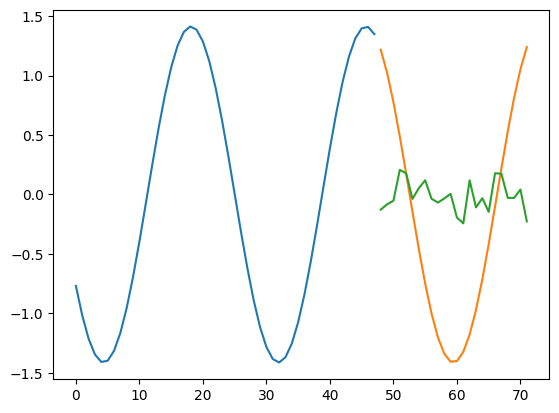

In [47]:
# Explanation

window_size = 48
steps_ahead = 24
interval = 1


train_loader = DataLoader(TimeSeriesDataset(df, window_size=window_size, steps_ahead=steps_ahead, data_split='train', intervals=interval), batch_size=32, shuffle=False) 

for x, F, y in train_loader:
    print('Shapes:\t', x.shape, F.shape, y.shape)
    break

model = SimpleMLP(input_size=window_size, forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=steps_ahead, rollout=False)

y_hat = model(x, F)

print('Output:\t', y_hat.shape)

print('Loss training:', model.training_step((x, F, y), 0))

plt.plot(range(window_size), x[0])
plt.plot(range(window_size, window_size + steps_ahead), y[0])
plt.plot(range(window_size, window_size + steps_ahead), y_hat[0].detach().numpy())

plt.show()

In [51]:
steps_ahead = 1
interval = 1

model = SimpleMLP(input_size=window_size, forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=steps_ahead, rollout=True, interval=interval)
log_name = f"SimpleMLP_{steps_ahead}_1"

train_loader = DataLoader(TimeSeriesDataset(df[:1000], window_size=window_size, steps_ahead=steps_ahead, data_split='train', intervals=interval), 
                          batch_size=32, shuffle=True)  

val_loader = DataLoader(TimeSeriesDataset(df[:1000], window_size=window_size, steps_ahead=steps_ahead, data_split='val', intervals=interval), 
                        batch_size=32, shuffle=False)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename=log_name,  save_top_k=1, mode='min')
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=True)

trainer = Trainer(max_epochs=100, 
                  callbacks=[checkpoint_callback, early_stop_callback])

# wandb_logger = WandbLogger(project="time-series-forecasting", name=log_name)

# trainer = Trainer(max_epochs=10, 
#                   callbacks=[checkpoint_callback, early_stop_callback], 
#                   logger=wandb_logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [52]:
trainer.fit(model, train_loader, val_loader)

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 6.5 K 
1 | fc2     | Linear  | 8.3 K 
2 | fc3     | Linear  | 65    
3 | loss_fn | MSELoss | 0     
------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.744


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.293 >= min_delta = 0.0. New best score: 0.451


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.227 >= min_delta = 0.0. New best score: 0.224


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.150 >= min_delta = 0.0. New best score: 0.074


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006
c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


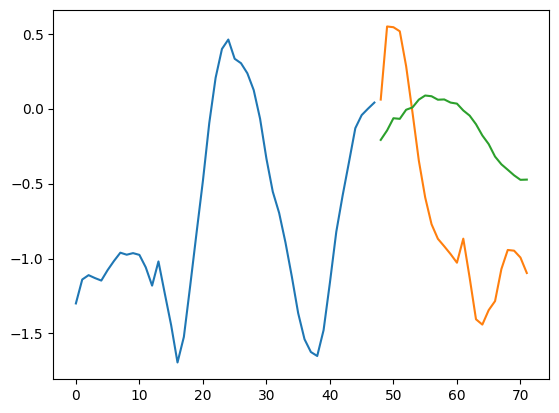

In [25]:
# model = SimpleMLP(input_size=window_size, forcing_size=2, output_size=steps_ahead, lr=0.0001, steps=steps_ahead, rollout=True)

model.steps = 24
time_series.plot_predictions(model, seed=50)